# 3D Wind Retrievals

In [1]:
%env ARTS_INCLUDE_PATH=/home/simon/src/arts_clean/controlfiles/
%env ARTS_DATA_PATH=/home/simon/src/arts_xml/
%env ARTS_BUILD_PATH=/home/simon/build/arts_production/arts

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from typhon.arts.workspace import Workspace, arts_agenda

env: ARTS_INCLUDE_PATH=/home/simon/src/arts_clean/controlfiles/
env: ARTS_DATA_PATH=/home/simon/src/arts_xml/
env: ARTS_BUILD_PATH=/home/simon/build/arts_production/arts
Loading ARTS API from: /home/simon/build/arts_production/arts/src/arts_api.so


This notebook is essentially a transcript of the `qpack_wind3d_demo.m` script which uses a
three-dimensional atmosphere to retrieve wind speeds.

In [2]:
ws = Workspace()

ws.execute_controlfile("general/general.arts")
ws.execute_controlfile("general/agendas.arts")
ws.execute_controlfile("general/continua.arts")
ws.execute_controlfile("general/planet_earth.arts")

ws.Copy(ws.abs_xsec_agenda,   ws.abs_xsec_agenda__noCIA)
ws.Copy(ws.ppath_agenda,      ws.ppath_agenda__FollowSensorLosPath)
ws.Copy(ws.ppath_step_agenda, ws.ppath_step_agenda__GeometricPath)
ws.Copy(ws.iy_space_agenda,   ws.iy_space_agenda__CosmicBackground)
ws.Copy(ws.iy_surface_agenda, ws.iy_surface_agenda__UseSurfaceRtprop)
ws.Copy(ws.iy_main_agenda,    ws.iy_main_agenda__Emission)
ws.Copy(ws.propmat_clearsky_agenda, ws.propmat_clearsky_agenda__OnTheFly)


ARTS[63876208]: Executing /home/simon/src/arts_clean/controlfiles/general/general.arts
ARTS[63876208]: {
ARTS[63876208]: - verbosityInit
ARTS[63876208]: - scat_speciesSet
ARTS[63876208]: - MatrixSet
ARTS[63876208]: - Tensor4SetConstant
ARTS[63876208]: - ArrayOfStringSet
ARTS[63876208]: - Touch
ARTS[63876208]: - FlagOff
ARTS[63876208]: - MatrixSet
ARTS[63876208]: - NumericSet
ARTS[63876208]: - ArrayOfStringSet
ARTS[63876208]: - Tensor3SetConstant
ARTS[63876208]: - Tensor3SetConstant
ARTS[63876208]: - Tensor3SetConstant
ARTS[63876208]: - Tensor3SetConstant
ARTS[63876208]: - Tensor3SetConstant
ARTS[63876208]: - Tensor3SetConstant
ARTS[63876208]: - IndexSet
ARTS[63876208]: - IndexSet
ARTS[63876208]: - IndexSet
ARTS[63876208]: - IndexSet
ARTS[63876208]: - FlagOff
ARTS[63876208]: - output_file_formatSetAscii
ARTS[63876208]: - StringSet
ARTS[63876208]: - IndexSet
ARTS[63876208]: - abs_lineshapeDefine
ARTS[63876208]: - NumericSet
ARTS[63876208]: - NumericSet
ARTS[63876208]: - AgendaSet
ARTS[63

## General Settings

For the wind retrievals, the forward model calculations are performed on a 3D atmosphere grid.
Radiation is assumed to be unpolarized.

In [3]:
ws.atmosphere_dim = 3
ws.stokes_dim     = 1
ws.iy_unit = "RJBT"

## Absorption

We only consider absorption from ozone in this example. The lineshape data is available from
the ARTS testdata available in `controlfiles/testdata`.

In [4]:
ws.abs_speciesSet(["O3", "H2O-PWR98"])
ws.abs_lineshapeDefine("Voigt_Kuntz6", "VVH", 750e9)
ws.ReadXML(ws.abs_lines, "testdata/ozone_line.xml")
ws.abs_lines_per_speciesCreateFromLines()

## Atmosphere (A Priori)

We create a pressure grid using the `PFromZSimple` function to create a grid of approximate pressure levels corresponding to altitudes in the range

$$
z = 0.0, 2000.0, \dots, 94000.0
$$

In [5]:
z_toa  = 95e3;
z_surf = 1e3;
z_grid = np.arange(z_surf - 1e3, z_toa, 2e3)
ws.PFromZSimple(ws.p_grid, z_grid)
ws.lat_grid = np.arange(-40.0, 1.0, 40.0)
ws.lon_grid = np.arange(40.0, 61.0, 20.0)
ws.z_surface = z_surf * np.ones((np.asarray(ws.lat_grid).size,
                                 np.asarray(ws.lon_grid).size))

For the a priori state we read data from the Fascod climatology that is part of the ARTS xml data.

In [6]:
ws.AtmRawRead(basename = "planets/Earth/Fascod/tropical/tropical")
ws.AtmFieldsCalcExpand1D()

## Adding Wind

Wind in ARTS is represented by the `wind_u_field` and `wind_v_field` WSVs, which hold the horizontal components of the wind at each grid point of the atmosphere model. For this example, a constant wind is assumed.

In [7]:
u_wind = 60.0
v_wind = -40.0
ws.wind_u_field = u_wind * np.ones((ws.p_grid.value.size,
                                    ws.lat_grid.value.size,
                                    ws.lon_grid.value.size))
ws.wind_v_field = v_wind * np.ones((ws.p_grid.value.size,
                                    ws.lat_grid.value.size,
                                    ws.lon_grid.value.size))
ws.wind_w_field = np.zeros((0,0,0))

## Frequency Grid and Sensor

The frequency grid for the simulation consists of 119 grid
points between 110.516 and 111.156 GHz. The frequencies
are given by a degree-10 polynomial that has been obtained from a fit to the data from the original `qpack` example. This is obscure but also kind of cool.

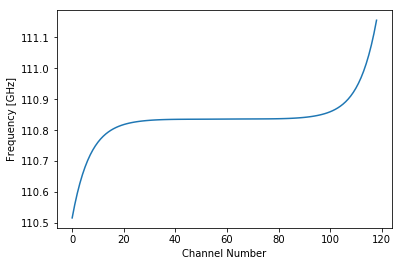

In [9]:
coeffs = np.array([5.06312189e-08, -2.68851772e-05, 6.20655463e-03,
                   -8.16344090e-01,   6.75337174e+01,  -3.66786505e+03,
                   1.32578167e+05,  -3.14514304e+06,   4.57491354e+07,
                   1.10516484e+11])
ws.f_grid = np.poly1d(coeffs)(np.arange(119))

plt.plot(ws.f_grid.value * 1e-9)
plt.xlabel("Channel Number")
plt.ylabel("Frequency [GHz]")



For the sensor we assume a channel width and channel spacing of 50 kHz. We also call `AntennaOff` to compute
only one pencilbeam along the line of sight of the sensor.

In [10]:
df = 50e3
f_backend = np.arange(ws.f_grid.value.min() + 2.0 * df, ws.f_grid.value.max() - 2.0 * df, df)
ws.backend_channel_responseGaussian(np.array([df]), np.array([2.0]))
ws.AntennaOff()

ws.sensor_norm = 1
ws.sensor_time = np.zeros(1)
ws.sensor_responseInit()

### Sensor Position and Viewing Geometry

5 Measurements are performed, one straight up, and four with zenith angle $70^\circ$ in directions SW, NW, NE, SE. In ARTS the measurement directions are given by a two-column matrix, where the first column contains the zenith angle and the second column the azimuth angle.

In [11]:
ws.sensor_los = np.array([[0.0, 0.0,],
                          [70.0, -135.0],
                          [70.0, -45.0],
                          [70.0, 45.0],
                          [70.0, 135.0]])
ws.sensor_pos = np.array([[2000.0, -21.1, 55.6]] * 5)

## Reference Measurement

Before we can calculate `y`, our setup needs to pass the following tests:

In [12]:
ws.abs_f_interp_order = 3
ws.propmat_clearsky_agenda_checkedCalc()
ws.sensor_checkedCalc()
ws.atmgeom_checkedCalc()
ws.atmfields_checkedCalc()
ws.abs_xsec_agenda_checkedCalc()
ws.cloudboxOff()
ws.jacobianOff()
ws.cloudbox_checkedCalc()

Now, we can run the simulation using the `yCalc` WSM and display the results. The results for all 5 measurements are stacked in `ws.y`.

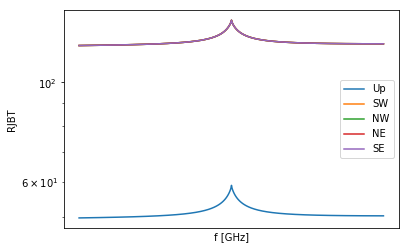

In [13]:
ws.yCalc()

# Plot results
y = np.copy(ws.y)
f = np.asarray(ws.f_grid)
labels = ["Up", "SW", "NW", "NE", "SE"]
for i,l in zip(range(0, y.size, y.size // 5), labels):
    plt.plot(f * 1e-9, y[i:i+f.size], label=l)
plt.xlabel("f [GHz]")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("RJBT")
plt.ylabel("RJBT")
plt.legend()

## Setting up the Retrieval

In this example, we retrieve ozone, the horizontal and vertical components of the wind velocities as well as a frequency shift and a polynomial baseline.

(array([ 50.]), array([-20.]))

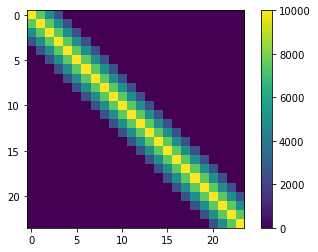

In [15]:
lat_ret_grid = np.array([np.mean(ws.lat_grid)])
lon_ret_grid = np.array([np.mean(ws.lon_grid)])
n_p = ws.p_grid.value.size

ws.retrievalDefInit()
ws.covmat1D(grid_1 = z_grid,
           sigma_1 = 0.1  * np.ones(n_p), # Relative uncertainty
           cls_1   = 10e3 * np.ones(n_p), # 10km correlation length
           fname   = "lin")
ws.retrievalAddAbsSpecies(species = "O3",
                          unit    = "rel",
                          g1      = ws.p_grid,
                          g2      = lat_ret_grid,
                          g3      = lon_ret_grid)
# Wind u-component
ws.covmat1D(grid_1 = z_grid[::2],
           sigma_1 = 100.0  * np.ones(n_p // 2), # Relative uncertainty
           cls_1   = 10e3 * np.ones(n_p // 2), # 10km correlation length
           fname   = "lin")
plt.imshow(ws.covmat_block.value.toarray())
plt.colorbar()
ws.retrievalAddWind(g1 = ws.p_grid.value[::2],
                    g2 = np.array([np.mean(ws.lat_grid)]),
                    g3 = np.array([np.mean(ws.lon_grid)]),
                    component = "u")
# Wind v-component
ws.covmat1D(grid_1 = z_grid[::2],
           sigma_1 = 100.0  * np.ones(n_p // 2), # Relative uncertainty
           cls_1   = 10e3 * np.ones(n_p // 2), # 10km correlation length
           fname   = "lin")
ws.retrievalAddWind(g1 = ws.p_grid.value[::2],
                    g2 = np.array([np.mean(ws.lat_grid)]),
                    g3 = np.array([np.mean(ws.lon_grid)]),
                    component = "v")
ws.retrievalDefClose()
ws.covmatDiagonal(0.000001 * np.ones(ws.y.value.shape))
ws.covmat_seSet()
ws.p_grid.value[::2].shape
(lon_ret_grid, lat_ret_grid)

In [16]:
@arts_agenda
def inversion_iterate_agenda(ws):
    ws.x2artsStandard()  
    ws.atmfields_checkedCalc()
    ws.atmgeom_checkedCalc()
    ws.yCalc()
    ws.Print(ws.y)
    ws.Print(ws.jacobian)
    ws.VectorAddVector( ws.yf, ws.y, ws.y_baseline )
    ws.jacobianAdjustAfterIteration() 
    
ws.Copy(ws.inversion_iterate_agenda, inversion_iterate_agenda)

## Jacobian

Let's have a look at the Jacobian to make sure our setup is sound.

In [ ]:
ws.jacobian_do = 1
ws.yCalc()

## Ozone

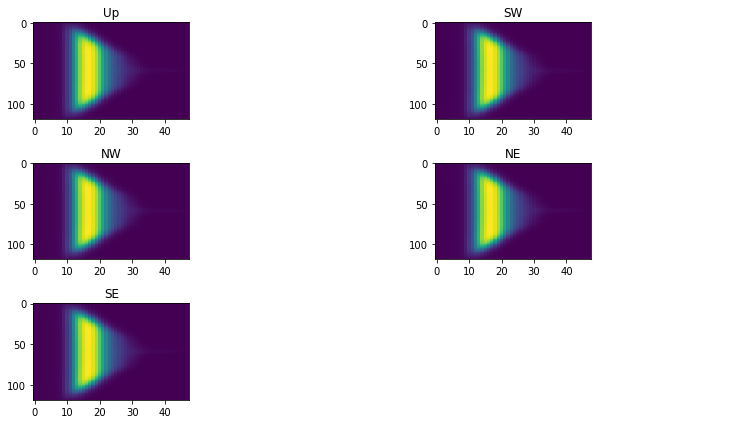

In [32]:
f, axs = plt.subplots(3,2, figsize=(12,6))
n_meas = ws.y.value.size // 5
for i in range(6):
    if i < 5:
        i_start = n_meas * i
        i_end   = n_meas * (i + 1)
        axs.ravel()[i].imshow(ws.jacobian.value[i_start:i_end, :n_p],
                              aspect=0.25)
        axs.ravel()[i].set_title(labels[i])
    else:
        axs.ravel()[i].axis("off")
plt.tight_layout()

## Zonal Winds

For zonal winds we plot the logarithm of the absolute value to visualize the different sensitivity scales throughout the model atmosphere.

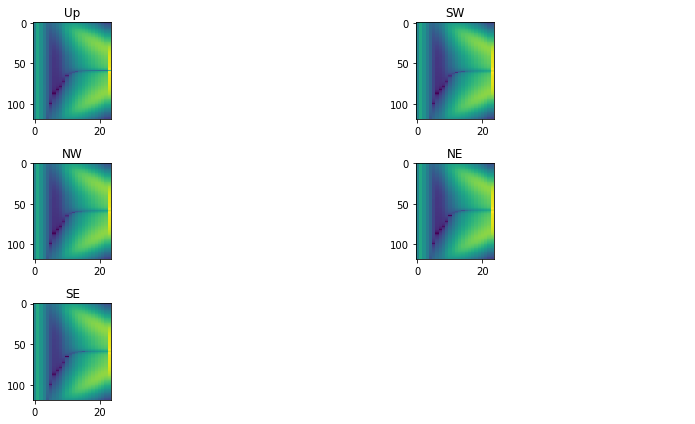

In [37]:
f, axs = plt.subplots(3,2, figsize=(12,6))
n_meas = ws.y.value.size // 5
for i in range(6):
    if i < 5:
        i_start = n_meas * i
        i_end   = n_meas * (i + 1)
        axs.ravel()[i].imshow(np.log(np.abs(ws.jacobian.value[i_start:i_end, n_p:3*n_p//2])),
                              aspect=0.25)
        axs.ravel()[i].set_title(labels[i])
    else:
        axs.ravel()[i].axis("off")
plt.tight_layout()

## Meridional Winds

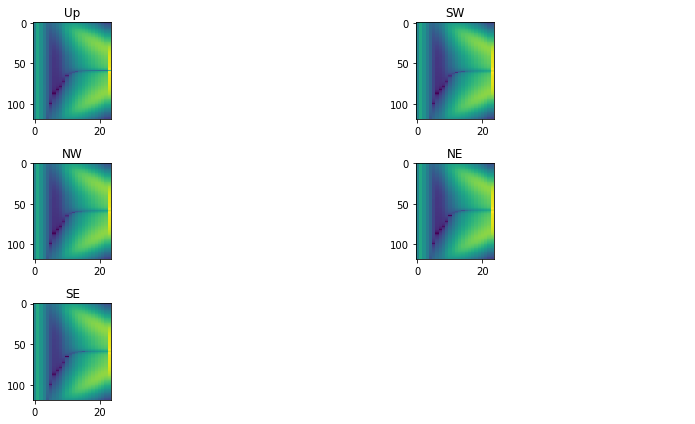

In [38]:
f, axs = plt.subplots(3,2, figsize=(12,6))
n_meas = ws.y.value.size // 5
for i in range(6):
    if i < 5:
        i_start = n_meas * i
        i_end   = n_meas * (i + 1)
        axs.ravel()[i].imshow(np.log(np.abs(ws.jacobian.value[i_start:i_end, n_p:3*n_p//2])),
                              aspect=0.25)
        axs.ravel()[i].set_title(labels[i])
    else:
        axs.ravel()[i].axis("off")
plt.tight_layout()

## A Priori State

For the a priori state we assume zero wind in any direction. The a priori vector for the OEM is created by the `xaStandard` WSM, which computes $x_a$ from the current atmospheric state.

In [20]:
ws.wind_u_field.value[:] = 0.0
ws.wind_v_field.value[:] = 0.0
ws.xaStandard()

# The OEM Calculation

In [21]:
ws.x        = np.zeros(0)
ws.jacobian = np.zeros((0,0))
ws.y.value[:] = y
ws.OEM(method="lm", max_iter=20, display_progress=1,
       lm_ga_settings=np.array([100.0,2.0,2.0,10.0,1.0,1.0]))


ARTS[63876208]: 
ARTS[63876208]:                                 MAP Computation                                
ARTS[63876208]: Formulation: Standard
ARTS[63876208]: Method:      Levenberg-Marquardt
ARTS[63876208]: 
ARTS[63876208]:  Step     Total Cost         x-Cost         y-Cost    Conv. Crit.   Gamma Factor
ARTS[63876208]: --------------------------------------------------------------------------------
ARTS[63876208]:     0        188.192              0        188.192                    100.000000
ARTS[63876208]:     1        187.637     0.00986398        187.627        3.30022      50.000000
ARTS[63876208]:     2        187.596     0.00999791        187.586     0.00019006      25.000000
ARTS[63876208]:     3        187.513      0.0100476        187.503     0.00054527      12.500000
ARTS[63876208]:     4        187.348      0.0100523        187.338    0.000269265       6.250000
ARTS[63876208]:     5        187.018      0.0100757        187.008     0.00100736       3.125000
ARTS[63

In [22]:
ws.x2artsStandard()

In [23]:
ws.wind_u_field.value

array([[[ 33.94486288,  33.94486288],
        [ 33.94486288,  33.94486288]],

       [[ 44.85379493,  44.85379493],
        [ 44.85379493,  44.85379493]],

       [[ 37.32020583,  37.32020583],
        [ 37.32020583,  37.32020583]],

       [[ 26.14050293,  26.14050293],
        [ 26.14050293,  26.14050293]],

       [[ 14.28282893,  14.28282893],
        [ 14.28282893,  14.28282893]],

       [[  3.00860707,   3.00860707],
        [  3.00860707,   3.00860707]],

       [[  1.25624295,   1.25624295],
        [  1.25624295,   1.25624295]],

       [[  2.31492751,   2.31492751],
        [  2.31492751,   2.31492751]],

       [[  5.57436935,   5.57436935],
        [  5.57436935,   5.57436935]],

       [[ 12.22122526,  12.22122526],
        [ 12.22122526,  12.22122526]],

       [[ 22.88857957,  22.88857957],
        [ 22.88857957,  22.88857957]],

       [[ 36.4354236 ,  36.4354236 ],
        [ 36.4354236 ,  36.4354236 ]],

       [[ 50.13837657,  50.13837657],
        [ 50.13837657,  50